In [37]:
%pip install -U textblob
!python -m textblob.download_corpora

%pip install nltk

%pip install --upgrade gensim

Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package brown to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finis

In [38]:
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

import gensim
from gensim.models import Word2Vec

from datetime import datetime

from IPython.display import Markdown, display
string = '# Start'
display(Markdown(string+' Coding'))

# Start Coding

In [39]:
def str_to_timestamp(s):
    out=[]

    s2=str.split(s,'+')
    s3=str.split(s2[0],' ')

    s4=str.split(s3[0],'-')

    s5=str.split(s3[1],':')
    year=int(s4[0])
    month=int(s4[1])
    day=int(s4[2])
    hour=int(s5[0])
    minute=int(s5[1])
    second=int(s5[2])

    return(datetime(year=year,month=month,day=day,hour=hour,minute=minute,second=second).timestamp())

from nltk.tokenize import word_tokenize

def NumStr(mot):
    res = ''.join(filter(lambda i: i.isdigit(), mot))
    if (res==''):
        return False
    return True


def extract_keywords(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Apply part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Select only nouns and adjectives
    keywords = [word for word, pos in tagged_tokens if (pos in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'] and not NumStr(word))]

    return keywords

def extract_sentiment_polarity(text):
    blob=TextBlob(text)
    return(blob.sentiment.polarity)

In [40]:
data=pd.read_csv('data/minnesota.csv')
df=data
print('start')

df['keywords'] = df['tweet_text'].apply(extract_keywords)

print('end of keywords')

df['sentiment_polarity']=df['tweet_text'].apply(extract_sentiment_polarity)

print('end of polarity')

df['timestamps']=df['tweet_created_dt'].apply(str_to_timestamp)
df['timestamps']=df['timestamps']-df['timestamps'].min()

print('end of timestamps')

clean_data=df

start
end of keywords
end of polarity
end of timestamps


In [41]:
def sliding_window(df,size,sliding):
    X_out=[]

    for time in range(0,int(df['timestamps'].max()),sliding):
        o=df[df.timestamps<time+size]
        X_out.append(o[o.timestamps>time])

        print("%.3f" % (time/int(df['timestamps'].max())), end="\r")
    print("finish")
    return X_out[:-1]

def dfToListofVectors(df):
    out=[]
    for l_vect in df.vectors:
        for v in l_vect:
            
            out.append(v)
            
    return out

In [42]:
time_day=60*60*24
L=sliding_window(clean_data,time_day*4,time_day)
first=L[0]

finish


In [43]:
vector_size=100
model = Word2Vec(sentences=first['keywords'], vector_size=vector_size, window=0, min_count=0, workers=0)
model.save("Word2vec_models/test_word2vec.model")
word_vectors = model.wv

In [44]:
i=0
for keywords in first.keywords:
    for keyword in keywords:
        i+=1

arr=np.ndarray((i,vector_size))
i=0
for keywords in first.keywords:

    for keyword in keywords:
        
        arr[i]=word_vectors[keyword]
        i+=1

## sklearn

In [45]:
from sklearn.cluster import k_means
from sklearn.cluster import KMeans
from sklearn.cluster import kmeans_plusplus
n_clusters=10
X=arr
kmeans=KMeans(n_clusters=n_clusters,n_init='auto')
kmeans.fit(X)

KMeans(n_clusters=10, n_init='auto')

In [46]:
centroids=kmeans.cluster_centers_
centroids.shape[0]

10

In [47]:
for i in range(centroids.shape[0]):
    print(word_vectors.similar_by_vector(centroids[i],topn=1))

[('good', 0.8186683058738708)]
[('matter', 1.0)]
[('black', 1.0000001192092896)]
[('i', 0.9999999403953552)]
[('supportingmyown', 0.4701400697231293)]
[('lynn', 0.5641313791275024)]
[('blacklivesmatter', 1.0)]
[('pandemic', 0.3952440023422241)]
[('lives', 0.9202662706375122)]
[('movement', 0.5205191969871521)]


In [48]:

itt=0
itt_max=len(L)
list_of_centroids=[]
list_of_centroids_with_words=[]
for seq in L[1:]:
    print("%.3f" % (itt/itt_max), end="\r")
    itt+=1
    if False:
        model = Word2Vec(sentences=seq['keywords'], vector_size=100, window=0, min_count=0, workers=0)
        model.save("Word2vec_models/test_word2vec.model")
        word_vectors = model.wv
        del model
    model.build_vocab(seq['keywords'], update=True)
    model.train(seq['keywords'], total_examples=model.corpus_count, epochs=model.epochs)
    word_vectors = model.wv
    

    i=0
    for keywords in seq.keywords:
        for keyword in keywords:
            i+=1

    arr=np.ndarray((i,100))
    i=0
    for keywords in seq.keywords:

        for keyword in keywords:
            
            arr[i]=word_vectors[keyword]
            i+=1
    X=arr
    #kmeans=k_means(X,n_clusters=5,n_init='auto')
    #centroids=kmeans[0]
    kmeans=KMeans(n_clusters=n_clusters,init=centroids,n_init=1)
    kmeans.fit(X)
    centroids=kmeans.cluster_centers_
    
    list_of_centroids.append(centroids)
    l_image_of_centroids=[]
    
    n_top_word=5
    for i in range(centroids.shape[0]):
        #print(word_vectors.similar_by_vector(centroids[i],topn=1))
        closest_word_of_centroid=word_vectors.similar_by_vector(centroids[i],topn=n_top_word)
        l_image_of_centroids.append(closest_word_of_centroid)
    list_of_centroids_with_words.append(l_image_of_centroids)
    #display(Markdown('### New centroids'))
    #for i in range(centroids.shape[0]):
        #print(word_vectors.similar_by_vector(centroids[i],topn=1))
print('finish')

finish


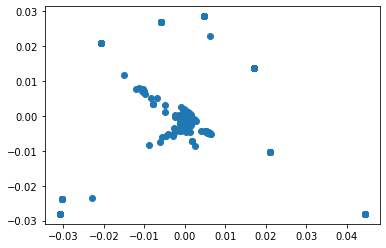

In [49]:
from sklearn.decomposition import PCA

i=0
all_centroids=np.ndarray((len(list_of_centroids*n_clusters),vector_size))
for centroids in list_of_centroids:
    for cent in centroids:            
        all_centroids[i]=cent
        i+=1
pca=PCA(n_components=2)
pca.fit(all_centroids)
X=pca.transform(all_centroids)
X
plt.scatter(X[:,0],X[:,1])

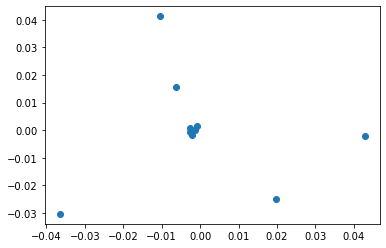

In [50]:
pca=PCA(n_components=2)
pca.fit(list_of_centroids[0])
X=pca.transform(list_of_centroids[0])
X
plt.scatter(X[:,0],X[:,1])

In [51]:
for i in range(len(list_of_centroids_with_words[0])):
    print(list_of_centroids_with_words[67][i][0])

('other', 1.0000001192092896)
('matter', 1.0)
('black', 1.0000001192092896)
('i', 0.9999999403953552)
('floyd', 0.8033826947212219)
('white', 1.0000001192092896)
('blacklivesmatter', 1.0)
('people', 1.0000001192092896)
('lives', 1.0)
('george', 0.6692883968353271)


In [52]:
for i in range(len(list_of_centroids_with_words)):
    print(list_of_centroids_with_words[i][8][0])

('lives', 0.9788944125175476)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 1.0)
('lives', 

In [53]:
bigL=np.ndarray((len(list_of_centroids_with_words),len(list_of_centroids_with_words[0])),dtype=object)
for i in range(bigL.shape[0]):
    for j in range(bigL.shape[1]) :
        bigL[i,j]=list_of_centroids_with_words[i][j][0][0]

In [54]:
bigL[:,0]

array(['good', 'good', 'good', 'peoples', 'peoples', 'peoples', 'peoples',
       'mural', 'frank', 'frank', 'frank', 'other', 'other', 'other',
       'other', 'other', 'other', 'hotline', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'riot', 'riot', 'riot',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 

In [55]:
verybigL=np.ndarray((len(list_of_centroids_with_words),len(list_of_centroids_with_words[0]),len(list_of_centroids_with_words[0][0])),dtype=object)
for i in range(verybigL.shape[0]):
    for j in range(verybigL.shape[1]) :
        for k in range(verybigL.shape[2]):
            verybigL[i,j,k]=list_of_centroids_with_words[i][j][k][0]

In [56]:
verybigL[:,0,0]

array(['good', 'good', 'good', 'peoples', 'peoples', 'peoples', 'peoples',
       'mural', 'frank', 'frank', 'frank', 'other', 'other', 'other',
       'other', 'other', 'other', 'hotline', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'riot', 'riot', 'riot',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 

In [57]:
veryverybigL=np.ndarray((len(list_of_centroids_with_words),len(list_of_centroids_with_words[0]),len(list_of_centroids_with_words[0][0]),len(list_of_centroids_with_words[0][0][0])),dtype=object)
veryverybigL.shape
for i in range(veryverybigL.shape[0]):
    for j in range(veryverybigL.shape[1]) :
        for k in range(veryverybigL.shape[2]):
            for l in range(veryverybigL.shape[3]):
                    veryverybigL[i,j,k,l]=list_of_centroids_with_words[i][j][k][l]

In [58]:
veryverybigL[:,1,0,0]

array(['matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matter',
       'matter', 'matter', 'matter', 'matter', 'matter', 'matt

In [59]:
centroids_array=np.ndarray((len(list_of_centroids),list_of_centroids[0].shape[0],list_of_centroids[0].shape[1]),dtype=object)
for i in range(centroids_array.shape[0]):
    centroids_array[i,:,:]=list_of_centroids[i]

In [60]:
(centroids_array[0,:,:]-centroids_array[119,:,:]>0.01).sum()

18

In [61]:
list_of_centroids_with_words[0][8]

[('lives', 0.9788944125175476),
 ('someone', 0.4452899992465973),
 ('icount', 0.2621156871318817),
 ('iraq', 0.23429103195667267),
 ('more', 0.22790610790252686)]

In [62]:
from numpy.linalg import norm
list_of_centroids[-1][0]
norm(word_vectors['black'])

0.056541704

In [63]:
l_sent=[]
for i in range(len(L)):
    l_sent.append(L[i].sentiment_polarity.mean())

n_tweets=[]
for i in range(len(L)):
    n_tweets.append(L[i].shape[0])


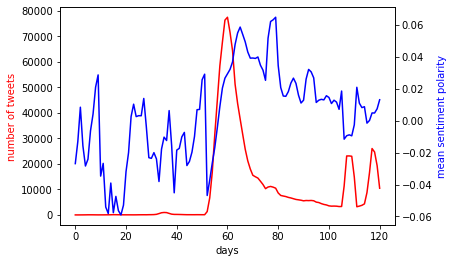

In [64]:
fig, axe1_X = plt.subplots()
axe2_X = axe1_X.twinx()
color1='red'
color2='blue'
axe1_X.plot(range(len(L)), n_tweets, color1)
axe2_X.plot(range(len(L)), l_sent, color2)
axe1_X.set_xlabel('days')
axe1_X.set_ylabel('number of tweets', color=color1)
axe2_X.set_ylabel('mean sentiment polarity', color=color2)
plt.savefig("figures_out/n_tweets_and_sent_pol.png",transparent=True)

In [65]:
for i in range(len(list_of_centroids[0])):
    print('centoids '+str(i)+ ':')
    print(word_vectors.similar_by_vector(list_of_centroids[-1][i],topn=5))

centoids 0:
[('other', 1.0000001192092896), ('palaces', 0.4275975525379181), ('wolfsburg', 0.42301952838897705), ('freeviet', 0.4156836271286011), ('inquiries', 0.41249164938926697)]
centoids 1:
[('matter', 1.0), ('maju', 0.4885726869106293), ('waaakeup', 0.42866745591163635), ('secuestrados', 0.42281877994537354), ('cultivates', 0.4094131290912628)]
centoids 2:
[('black', 1.0000001192092896), ('maybe…', 0.4183979034423828), ('nyferry', 0.39317986369132996), ('extinguishracism', 0.38805198669433594), ('traquer', 0.3873019516468048)]
centoids 3:
[('i', 0.9999999403953552), ('paygap', 0.4506978690624237), ('arde', 0.40925562381744385), ('socialartist', 0.4004528224468231), ('estreetradio', 0.39781174063682556)]
centoids 4:
[('floyd', 0.9999998807907104), ('fastfood', 0.4020780920982361), ('soyledigim', 0.39591509103775024), ('jolivet', 0.3943294286727905), ('otherization', 0.39247387647628784)]
centoids 5:
[('white', 1.0000001192092896), ('blacklivesmatter//everyday', 0.4137064218521118)

In [67]:
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance
NUM_CLUSTERS = 5
data = X

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=cosine_distance, repeats=10,avoid_empty_clusters=True)

assigned_clusters = kclusterer.cluster(data,assign_clusters=True)

for i in range(NUM_CLUSTERS):
    print('centroid '+str(i)+' :')
    print(word_vectors.similar_by_vector(kclusterer.means()[i],topn=5))

1
2
centroid 0 :
[('lives', 0.7291445732116699), ('movement', 0.4110577702522278), ('eternity', 0.3848576545715332), ('rate', 0.34057506918907166), ('blackwoman', 0.3382153809070587)]
centroid 1 :
[('black', 0.9325089454650879), ('african', 0.31351590156555176), ('people', 0.31224629282951355), ('years', 0.297455757856369), ('bad', 0.2882227301597595)]
centroid 2 :
[('matter', 0.8607635498046875), ('sad', 0.40408676862716675), ('bitch', 0.3503803014755249), ('mothers', 0.31834670901298523), ('horror', 0.30992811918258667)]
centroid 3 :
[('i', 0.8460559844970703), ('time', 0.37904027104377747), ('blacklove', 0.35884836316108704), ('production', 0.3357827663421631), ('americans', 0.3329533636569977)]
centroid 4 :
[('blacklivesmatter', 0.9081574082374573), ('day', 0.27967700362205505), ('good', 0.2722136080265045), ('homeless', 0.26820752024650574), ('love', 0.2591080069541931)]


In [324]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

time_day=60*60*24
nb_bins=int(clean_data['timestamps'].max()/time_day)
coef_smooth=int(nb_bins/10)

hist,e=np.histogram(clean_data['timestamps'],nb_bins)
smooth_hist=smooth(hist,coef_smooth)
x_hist=range(nb_bins)
dhist=np.gradient(smooth_hist,x_hist)
#plt.plot(x_hist,dhist)
the_time=e[dhist.argmax()]

We want to identify the weak signal before this time ( which is the time where the number of tweets increase the most) and as soon as possible

In [394]:
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance
NUM_CLUSTERS = 10

time_day=60*60*24


clean_data2=clean_data[clean_data['timestamps']<the_time]


L_cos=sliding_window(clean_data2,time_day*3,time_day//2)
first=L_cos[0]
print(len(L_cos))
#L_cos=L_cos[0:2*len(L_cos)//6]
first

finish
112


,tweet_id,tweet_created_dt,retweets,favorites,tweet_text,keywords,sentiment_polarity,timestamps
1,1245142183063289859,2020-04-01 00:13:24,0,3,i agree #blacklivesmatter,"[i, blacklivesmatter]",0.000000,249.0
2,1245161385392320515,2020-04-01 01:29:42,0,0,i guess racism made them do it. can not we all...,"[i, guess, racism, memo, black, matter]",-0.166667,4827.0
3,1245202864001167360,2020-04-01 04:14:32,0,0,census 2020 complete! #census2020 #blacklivesm...,"[census, complete, blacklivesmatter, myvoice, ...",0.125000,14717.0
4,1245333473709129728,2020-04-01 12:53:31,0,0,there is a video online of a cop. speaking out...,"[video, online, cop, black, matter, movements,...",-0.413889,45856.0
5,1245397493283684353,2020-04-01 17:07:55,0,2,lynn is losing it #blacklightning #blacklivesm...,"[lynn, blacklivesmatter, coronalockdown]",0.000000,61120.0
6,1245405357960310785,2020-04-01 17:39:10,0,1,oh damn lynn #blacklightning #aprilfoolsday #b...,"[damn, lynn, aprilfoolsday, blacklivesmatter, ...",0.000000,62995.0
7,1245422556720619520,2020-04-01 18:47:31,2,3,to all the transpeople who may see this you ar...,"[transpeople, day, year, transdayofvisibility,...",0.000000,67096.0
8,1245443609039646722,2020-04-01 20:11:10,0,0,mother is burden #blacklivesmatter #mothers #m...,"[mother, burden, mothers, socialjustice, black...",0.000000,72115.0
9,1245487111668666368,2020-04-01 23:04:02,0,1,jen dont do it #blacklightning #coronavirus #n...,"[jen, dont, coronavirus, blacklivesmatter, que...",0.000000,82487.0
10,1245516178237374465,2020-04-02 00:59:32,4,2,and i do not believe they deserve the position...,"[position, school, difference, university, sou...",-0.333333,89417.0


In [395]:
vector_size=100
model = Word2Vec(sentences=first['keywords'], vector_size=vector_size, window=0, min_count=0, workers=0)
model.save("Word2vec_models/test_word2vec.model")
word_vectors = model.wv

i=0
for keywords in first.keywords:
    for keyword in keywords:
        i+=1

arr=np.ndarray((i,vector_size))
i=0
for keywords in first.keywords:

    for keyword in keywords:
        
        arr[i]=word_vectors[keyword]
        i+=1

X=arr
print(X.shape)

(163, 100)


In [396]:
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=cosine_distance, repeats=10,avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X,assign_clusters=True)

L_centroids=kclusterer.means()

l_image_of_centroids=[]
    
n_top_word=5
for i in range(len(L_centroids)):
        #print(word_vectors.similar_by_vector(centroids[i],topn=1))
    closest_word_of_centroid=word_vectors.similar_by_vector(L_centroids[i],topn=n_top_word)
    l_image_of_centroids.append(closest_word_of_centroid)

In [397]:
itt=0
itt_max=len(L_cos)
list_of_centroids_cos=[L_centroids]
list_of_centroids_with_words_cos=[l_image_of_centroids]
for seq in L_cos[1:]:
    print("%.3f" % (itt/itt_max), end="\r")
    itt+=1
    if False:
        model = Word2Vec(sentences=seq['keywords'], vector_size=100, window=0, min_count=0, workers=0)
        model.save("Word2vec_models/test_word2vec.model")
        word_vectors = model.wv
        del model
    model.build_vocab(seq['keywords'], update=True)
    model.train(seq['keywords'], total_examples=model.corpus_count, epochs=model.epochs)
    word_vectors = model.wv
    

    i=0
    for keywords in seq.keywords:
        for keyword in keywords:
            i+=1

    arr=np.ndarray((i,100))
    i=0
    for keywords in seq.keywords:

        for keyword in keywords:
            
            arr[i]=word_vectors[keyword]
            i+=1
    X=arr
    #kmeans=k_means(X,n_clusters=5,n_init='auto')
    #centroids=kmeans[0]
    if False:
        kmeans=KMeans(n_clusters=n_clusters,init=centroids,n_init=1)
        kmeans.fit(X)
        centroids=kmeans.cluster_centers_
    kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=cosine_distance,avoid_empty_clusters=True,initial_means=L_centroids,repeats=1)
    assigned_clusters = kclusterer.cluster(X,assign_clusters=True)
    L_centroids=kclusterer.means()
    


    list_of_centroids_cos.append(L_centroids)
    l_image_of_centroids=[]
    
    n_top_word=5
    for i in range(len(L_centroids)):
        #print(word_vectors.similar_by_vector(centroids[i],topn=1))
        closest_word_of_centroid=word_vectors.similar_by_vector(L_centroids[i],topn=n_top_word)
        l_image_of_centroids.append(closest_word_of_centroid)
    list_of_centroids_with_words_cos.append(l_image_of_centroids)
    #display(Markdown('### New centroids'))
    #for i in range(centroids.shape[0]):
        #print(word_vectors.similar_by_vector(centroids[i],topn=1))
print('finish')

finish


In [398]:

L_dist=[]
for j in range(len(list_of_centroids_cos[i])):
    L_dist_per_cluster=[0]
    for i in range(1,len(list_of_centroids_cos)-2):
        L_dist_per_cluster.append(cosine_distance(list_of_centroids_cos[i][j],list_of_centroids_cos[i-1][j]))
    L_dist.append(L_dist_per_cluster)
    print("max distance for cluster "+str(j)+" = %f"%np.asarray(L_dist_per_cluster).max())

max distance for cluster 0 = 0.412957
max distance for cluster 1 = 0.491471
max distance for cluster 2 = 0.506948
max distance for cluster 3 = 0.652185
max distance for cluster 4 = 0.373497
max distance for cluster 5 = 0.085356
max distance for cluster 6 = 0.171042
max distance for cluster 7 = 0.464951
max distance for cluster 8 = 0.077221
max distance for cluster 9 = 0.150969


In [399]:
L_ind=[]
for i in range(len(L_dist)):
    print('indice de déplacement de la moyenne des points du cluster n°'+str(i)+" : %d"%np.where(np.asarray(L_dist[i])==np.asarray(L_dist[i]).max())[0][0])
    L_ind.append(np.where(np.asarray(L_dist[i])==np.asarray(L_dist[i]).max())[0][0])
    #print(np.where(np.asarray(L_dist[i_max])==np.asarray(L_dist[i_max]).max()))


indice de déplacement de la moyenne des points du cluster n°0 : 106
indice de déplacement de la moyenne des points du cluster n°1 : 2
indice de déplacement de la moyenne des points du cluster n°2 : 106
indice de déplacement de la moyenne des points du cluster n°3 : 106
indice de déplacement de la moyenne des points du cluster n°4 : 106
indice de déplacement de la moyenne des points du cluster n°5 : 2
indice de déplacement de la moyenne des points du cluster n°6 : 2
indice de déplacement de la moyenne des points du cluster n°7 : 106
indice de déplacement de la moyenne des points du cluster n°8 : 106
indice de déplacement de la moyenne des points du cluster n°9 : 106


In [400]:
list_of_centroids_with_words_cos[106]

[[('minneapolis', 0.6786524653434753),
  ('justiceforfloyd', 0.4172207713127136),
  ('pro-slavery', 0.40469372272491455),
  ('shit', 0.3777412474155426),
  ('real', 0.3543720245361328)],
 [('sayhisname', 0.5476949214935303),
  ('amycooper', 0.45418068766593933),
  ('angry', 0.37085020542144775),
  ('important', 0.36577650904655457),
  ('thank', 0.3426130712032318)],
 [('floyd', 0.7906460165977478),
  ('police', 0.5066380500793457),
  ('people', 0.46485888957977295),
  ('workout', 0.3901790678501129),
  ('todays', 0.3431520462036133)],
 [('georgefloyd', 0.9117944240570068),
  ('matter', 0.39925849437713623),
  ('behind', 0.3857111632823944),
  ('first', 0.3645626902580261),
  ('evil', 0.3563770353794098)],
 [('video', 0.7098432183265686),
  ('nothing', 0.3721890151500702),
  ('someone', 0.36040374636650085),
  ('world', 0.34462442994117737),
  ('climbs', 0.34185367822647095)],
 [('blacklivesmatter', 0.9140677452087402),
  ('man', 0.5099648833274841),
  ('angela', 0.36522868275642395),
 

In [393]:
L_cos[106]

,tweet_id,tweet_created_dt,retweets,favorites,tweet_text,keywords,sentiment_polarity,timestamps
2255,1264350575640092673,2020-05-24 00:20:42,0,1,"we noticed. long ago, i thought, ""if being a r...","[long, i, racist, racist, ncaa, trump, black, ...",0.022396,4579887.0
2256,1264359915298205696,2020-05-24 00:57:49,0,0,princess love requests full custody of two kid...,"[princess, love, requests, full, custody, kids...",0.425000,4582114.0
2257,1264360745778778112,2020-05-24 01:01:07,0,1,#harlem #blackhistory #blackhistorymonth #blac...,"[harlem, blackhistory, blackhistorymonth, blac...",0.000000,4582312.0
2258,1264521913294098432,2020-05-24 11:41:32,0,0,"if you really want to f#ck up some folks, pain...","[folks, paint, whichever, side, face, opposite...",-0.013426,4620737.0
2259,1264526041244205056,2020-05-24 11:57:56,0,1,black lives do not matter to the democrat part...,"[black, lives, democrat, party, black, votes]",-0.069444,4621721.0
...,...,...,...,...,...,...,...,...
3565,1265433705478316034,2020-05-27 00:04:40,0,4,can not believe its 2020 and the descenders of...,"[descenders, jim, crow, empowered, real, justi...",-0.044444,4838125.0
3566,1265433717914378244,2020-05-27 00:04:43,0,1,do you understand now? or are your eyes still ...,"[eyes, georgefloyd, north, carolina]",0.000000,4838128.0
3567,1265433727087362049,2020-05-27 00:04:45,0,0,i am tired #georgefloyd,"[i, georgefloyd]",-0.400000,4838130.0
3568,1265433755596083201,2020-05-27 00:04:52,0,1,#georgefloyd say his name.,"[georgefloyd, name]",0.000000,4838137.0


In [384]:
l_sent_cos=[]
for i in range(len(L_cos)):
    l_sent_cos.append(L_cos[i].sentiment_polarity.mean())

n_tweets_cos=[]
for i in range(len(L_cos)):
    n_tweets_cos.append(L_cos[i].shape[0])


Text(0, 0.5, 'mean sentiment polarity')

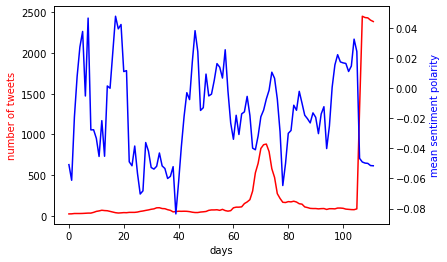

In [385]:

fig, axe1_X = plt.subplots()
axe2_X = axe1_X.twinx()
color1='red'
color2='blue'
axe1_X.plot(range(len(L_cos)), n_tweets_cos, color1)
axe2_X.plot(range(len(L_cos)), l_sent_cos, color2)
axe1_X.set_xlabel('days')
axe1_X.set_ylabel('number of tweets', color=color1)
axe2_X.set_ylabel('mean sentiment polarity', color=color2)